# **Intro**

In [ ]:
# Importing library

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from datetime import datetime, date

# **Functions**

In [ ]:
# Reset random seed

def reset_random_seeds(seed_value=1):
   os.environ['PYTHONHASHSEED']=str(seed_value)
   tf.random.set_seed(seed_value)
   np.random.seed(seed_value)
   random.seed(seed_value)

In [ ]:
# Date-time Parsing

def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

In [ ]:
# Dickey-Fuller Test (check stationarity) Function

from statsmodels.tsa.stattools import  adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
        return True
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
        return False

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Differencing

def difference(data, times=1):
  data_diff = data.diff()
  data_diff.dropna(inplace=True)
  if times == 0:
    return data
  elif times == 1:
    return data_diff
  else:
    for i in range(0,times-1):
      data_diff = data_diff.diff()
      data_diff.dropna(inplace=True)
    return data_diff

In [ ]:
# Inverse difference

def inverse_difference(series, differenced, times_diff):
  for n in range(1,times_diff+1):
    inverted = list()
    seed = difference(series,times_diff-n)[times_diff-n]
    inverted.append(seed)
    for i in range(len(differenced)):
	    value = inverted[i] + differenced[i]
	    inverted.append(value)
    differenced = pd.Series(inverted.copy())
  inverted_difference = differenced.copy()
  return inverted_difference

In [ ]:
# Creating history dataframe

def create_dataframe(history):
  history_df = pd.DataFrame(history.history)
  history_df['epoch'] = history.epoch

  return history_df

In [ ]:
# Evaluate history loss

def evaluate_history_loss(history_df):
  # Locate min loss
  min_loss_index = history_df[history_df['loss']==min(history_df['loss'])].index.values
  min_loss = history_df.loc[min_loss_index]['loss']

  # Plot lines
  plt.plot(history_df['loss'], label='loss', c='tab:blue')
  # Plot marking points
  plt.plot(min_loss_index, min_loss, 'o', ms=7.5, label='min loss', c='tab:blue', mec='k', mew=0.75)
  # Show plot
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.grid(True)
  plt.show()

  
  # Print informations
  print("Minimum loss :", min_loss)

In [ ]:
# Evaluate history cosine_similarity

def evaluate_history_cosine_similarity(history_df):
  # Locate max cosine_similarity
  max_cos_sim_index = history_df[history_df['cosine_similarity']==max(history_df['cosine_similarity'])].index.values
  max_cos_sim = history_df.loc[max_cos_sim_index]['cosine_similarity']

  # Plot lines
  plt.plot(history_df['cosine_similarity'], label='cosine_similarity', c='tab:blue')
  # Plot marking points
  plt.plot(max_cos_sim_index, max_cos_sim, 'o', ms=7.5, label='max cosine_similarity', c='tab:blue', mec='k', mew=0.75)
  # Show plot
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (cosine similarity)')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.grid(True)
  plt.show()

  
  # Print informations
  print("Maximum cosine similarity :", max_cos_sim)

In [ ]:
# Numerical metrics evaluation

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate_metrics(y_true, y_pred):
  r2 = r2_score(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)

  print("R^2 score :", '{:.5f}'.format(r2))
  print("MAE (Mean Absolute Error) :", '{:.5f}'.format(mae))
  print("MSE (Mean Squared Error) :", '{:.5f}'.format(mse))
  print("RMSE (Root Mean Squared Error) :", '{:.5f}'.format(rmse))

# **Data Preparations**

## **Load Dataset**

In [ ]:
# Load dataset

path = 'drive/My Drive/Final_project/Dataset/covid_19_clean_complete.csv'
dataset = pd.read_csv(path, date_parser=parser, parse_dates=[4])
dataset = dataset.rename(columns={"Country/Region": "Country_Reg", "Province/State":"Prov_State"})

In [ ]:
dataset.head()

,Prov_State,Country_Reg,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Prov_State   14664 non-null  object        
 1   Country_Reg  49068 non-null  object        
 2   Lat          49068 non-null  float64       
 3   Long         49068 non-null  float64       
 4   Date         49068 non-null  datetime64[ns]
 5   Confirmed    49068 non-null  int64         
 6   Deaths       49068 non-null  int64         
 7   Recovered    49068 non-null  int64         
 8   Active       49068 non-null  int64         
 9   WHO Region   49068 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 3.7+ MB


In [ ]:
dataset['Country_Reg'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Greenland', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India', 'Ind

## **Filter 1 country only**

In [ ]:
# Excluding China

firstdate = dataset[:261]
firstdate = firstdate.query('Country_Reg != "China"')
firstdate.sort_values('Confirmed', ascending=False).head()

,Prov_State,Country_Reg,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
207,NaN,Thailand,15.870032,100.992541,2020-01-22,2,0,0,2,South-East Asia
137,NaN,Japan,36.204824,138.252924,2020-01-22,2,0,0,2,Western Pacific
223,NaN,US,40.000000,-100.000000,2020-01-22,1,0,0,1,Americas
205,NaN,Taiwan*,23.700000,121.000000,2020-01-22,1,0,0,1,Western Pacific
141,NaN,South Korea,35.907757,127.766922,2020-01-22,1,0,0,1,Western Pacific


In [ ]:
# Select country

country_df = dataset.query('Country_Reg == "Thailand"')
country_df

,Prov_State,Country_Reg,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
207,NaN,Thailand,15.870032,100.992541,2020-01-22,2,0,0,2,South-East Asia
468,NaN,Thailand,15.870032,100.992541,2020-01-23,3,0,0,3,South-East Asia
729,NaN,Thailand,15.870032,100.992541,2020-01-24,5,0,0,5,South-East Asia
990,NaN,Thailand,15.870032,100.992541,2020-01-25,7,0,0,7,South-East Asia
1251,NaN,Thailand,15.870032,100.992541,2020-01-26,8,0,2,6,South-East Asia
...,...,...,...,...,...,...,...,...,...,...
47970,NaN,Thailand,15.870032,100.992541,2020-07-23,3279,58,3107,114,South-East Asia
48231,NaN,Thailand,15.870032,100.992541,2020-07-24,3279,58,3107,114,South-East Asia
48492,NaN,Thailand,15.870032,100.992541,2020-07-25,3282,58,3109,115,South-East Asia
48753,NaN,Thailand,15.870032,100.992541,2020-07-26,3291,58,3109,124,South-East Asia


In [ ]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 207 to 49014
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Prov_State   0 non-null      object        
 1   Country_Reg  188 non-null    object        
 2   Lat          188 non-null    float64       
 3   Long         188 non-null    float64       
 4   Date         188 non-null    datetime64[ns]
 5   Confirmed    188 non-null    int64         
 6   Deaths       188 non-null    int64         
 7   Recovered    188 non-null    int64         
 8   Active       188 non-null    int64         
 9   WHO Region   188 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 16.2+ KB


In [ ]:
# Replace index with datetime
country_df.index = country_df['Date']

# Filter important columns
cols = ['Confirmed', 'Deaths', 'Recovered', 'Active']
country_df = country_df.filter(items=cols, axis=1)

In [ ]:
country_df

,Confirmed,Deaths,Recovered,Active
Date,,,,
2020-01-22,2,0,0,2
2020-01-23,3,0,0,3
2020-01-24,5,0,0,5
2020-01-25,7,0,0,7
2020-01-26,8,0,2,6
...,...,...,...,...
2020-07-23,3279,58,3107,114
2020-07-24,3279,58,3107,114
2020-07-25,3282,58,3109,115


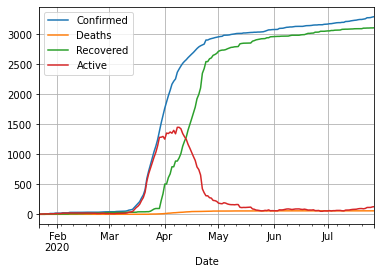

In [ ]:
# Plot timeseries data

country_df.plot(grid=True)
plt.show()

## **Filter 1 column only**

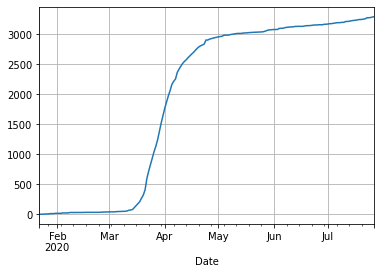

In [ ]:
ts_df = country_df['Confirmed']
ts_df.plot(grid=True)
plt.show()

# **Feature Engineering**

## **Stationarity Test**

In [ ]:
# Check stationarity after differencing

diff_checker = 5

for times_diff in range(diff_checker+1):
  name = 'Differenced ' + str(times_diff) + ' times'
  adf_test = adfuller_test(difference(ts_df,times_diff), name=name)
  if adf_test:
    break
  print('\n')

    Augmented Dickey-Fuller Test on "Differenced 0 times" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3638
 No. Lags Chosen       = 11
 Critical value 1%     = -3.468
 Critical value 5%     = -2.878
 Critical value 10%    = -2.576
 => P-Value = 0.5995. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Differenced 1 times" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.781
 No. Lags Chosen       = 10
 Critical value 1%     = -3.468
 Critical value 5%     = -2.878
 Critical value 10%    = -2.576
 => P-Value = 0.061. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Differenced 2 times" 
    -------------------------------------

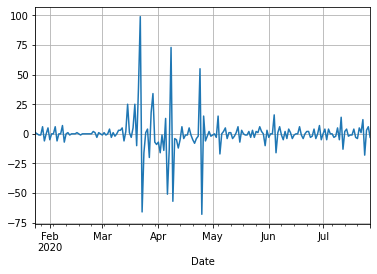

In [ ]:
# Show plot after differencing

diffed = difference(ts_df, times=times_diff)
diffed.plot(grid=True)
plt.show()

## **Lag Test**

In [ ]:
# Import library

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

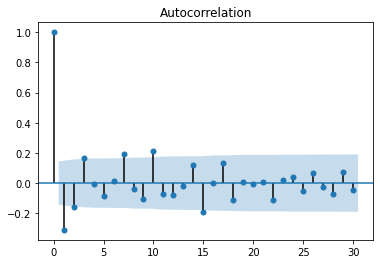

In [ ]:
# Plot ACF

plot_acf(diffed, lags=30, ax=plt.gca())
plt.show()

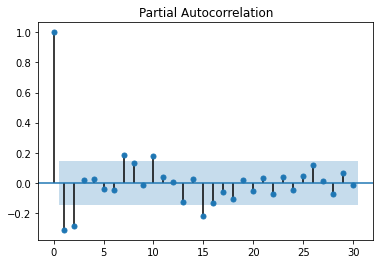

In [ ]:
# Plot PACF

plot_pacf(diffed, lags=30, ax=plt.gca())
plt.show()

In [ ]:
# Summary

lag = 4

## **Preprocess**

### Make supervised data

In [ ]:
# Make supervised dataframe

supervised_df = pd.DataFrame(diffed)
columns = [supervised_df.shift(lag+1-i) for i in range(1, lag+1)]
columns.append(supervised_df)
supervised_df = pd.concat(columns, axis=1)
supervised_df.fillna(0, inplace=True)
supervised_df.columns = range(lag+1)

supervised_df.head()

,0,1,2,3,4
Date,,,,,
2020-01-24,0.0,0.0,0.0,0.0,1.0
2020-01-25,0.0,0.0,0.0,1.0,0.0
2020-01-26,0.0,0.0,1.0,0.0,-1.0
2020-01-27,0.0,1.0,0.0,-1.0,-1.0
2020-01-28,1.0,0.0,-1.0,-1.0,6.0


In [ ]:
# Get supervised values

supervised_values = supervised_df.values

### Scaling

In [ ]:
# Train-test split

train_set = supervised_values.copy()

In [ ]:
# Scaling

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)

train_scaled = scaler.transform(train_set)

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]

# **Create & Fit Models**

In [ ]:
# Import library

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.layers import Flatten, TimeDistributed
from tensorflow.keras.layers import ConvLSTM2D
from keras.layers.convolutional import Conv1D, MaxPooling1D

models = []

In [ ]:
# Train intensity

epoch = 1000
batch_size = 32

## Vanilla LSTM Model

In [ ]:
# Reshape dari [jumlah sample, timesteps]
# menjadi [jumlah sample, timesteps (lag), jumlah feature]

n_features = 1

feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], feature_train.shape[1], n_features))

feature_train_vanilla = feature_train_reshaped.copy()

In [ ]:
# Create Vanilla LSTM Model

reset_random_seeds()

block = 50

lstm_vanilla = Sequential()
lstm_vanilla.add(LSTM(block, activation='relu', input_shape=(lag, n_features)))
lstm_vanilla.add(Dense(1))
lstm_vanilla.compile(optimizer='adam', loss='mean_squared_error', metrics='cosine_similarity')

lstm_vanilla.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit Vanilla LSTM Model

history_lstm_vanilla = lstm_vanilla.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, verbose=0, shuffle=False)
print("Fitting Done")

models.append({'model':lstm_vanilla, 'history':history_lstm_vanilla, 'name':"Vanilla LSTM Model", 'feature train':feature_train_vanilla})

Fitting Done


## Stacked LSTM Model

In [ ]:
# Reshape dari [jumlah sample, timesteps]
# menjadi [jumlah sample, timesteps (lag), jumlah feature]

n_features = 1

feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], feature_train.shape[1], n_features))

feature_train_stacked = feature_train_reshaped.copy()

In [ ]:
# Create Stacked LSTM Model

reset_random_seeds()

block = 50

lstm_stacked = Sequential()
lstm_stacked.add(LSTM(block, activation='relu', return_sequences=True, input_shape=(lag, n_features)))
lstm_stacked.add(LSTM(block, activation='relu'))
lstm_stacked.add(Dense(1))
lstm_stacked.compile(optimizer='adam', loss='mean_squared_error', metrics='cosine_similarity')

lstm_stacked.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 50)             10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit Stacked LSTM Model

history_lstm_stacked = lstm_stacked.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, verbose=0, shuffle=False)
print("Fitting Done")

models.append({'model':lstm_stacked, 'history':history_lstm_stacked, 'name':"Stacked LSTM Model", 'feature train':feature_train_stacked})

Fitting Done


## Bidirectional LSTM Model

In [ ]:
# Reshape dari [jumlah sample, timesteps]
# menjadi [jumlah sample, timesteps (lag), jumlah feature]

n_features = 1

feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], feature_train.shape[1], n_features))

feature_train_bidir = feature_train_reshaped.copy()

In [ ]:
# Create Bidirectional LSTM Model

reset_random_seeds()

block = 50

lstm_bidir = Sequential()
lstm_bidir.add(Bidirectional(LSTM(block, activation='relu'), input_shape=(lag, n_features)))
lstm_bidir.add(Dense(1))
lstm_bidir.compile(optimizer='adam', loss='mean_squared_error', metrics='cosine_similarity')

lstm_bidir.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               20800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit Bidirectional LSTM Model

history_lstm_bidir = lstm_bidir.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, verbose=0, shuffle=False)
print("Fitting Done")

models.append({'model':lstm_bidir, 'history':history_lstm_bidir, 'name':"Bidirectional LSTM Model", 'feature train':feature_train_bidir})

Fitting Done


## CNN LSTM

In [ ]:
# Reshape dari [jumlah sample, timesteps]
# menjadi [jumlah sample, subsequences (akar lag), timesteps (akar lag), jumlah feature]
# Hanya bisa dipakai saat lag = bilangan kuadratik

n_seq = int(np.sqrt(feature_train.shape[1]))
n_steps = int(np.sqrt(feature_train.shape[1]))
n_features = 1

feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], n_seq, n_steps, n_features))

feature_train_cnn = feature_train_reshaped.copy()

In [ ]:
# Create CNN LSTM Model

reset_random_seeds()

block = 50

lstm_cnn = Sequential()
lstm_cnn.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
lstm_cnn.add(TimeDistributed(MaxPooling1D(pool_size=2)))
lstm_cnn.add(TimeDistributed(Flatten()))
lstm_cnn.add(LSTM(block, activation='relu'))
lstm_cnn.add(Dense(1))
lstm_cnn.compile(optimizer='adam', loss='mean_squared_error', metrics='cosine_similarity')

lstm_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 2, 64)       128       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 23,179
Trainable params: 23,179
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit CNN LSTM Model

history_lstm_cnn = lstm_cnn.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, verbose=0)
print("Fitting Done")

models.append({'model':lstm_cnn, 'history':history_lstm_cnn, 'name':"CNN LSTM Model", 'feature train':feature_train_cnn})

Fitting Done


## ConvLSTM

In [ ]:
# Reshape dari [jumlah sample, timesteps]
# menjadi [jumlah sample, subsequences (akar lag), timesteps (akar lag), jumlah feature]
# Hanya bisa dipakai saat lag = bilangan kuadratik

n_seq = int(np.sqrt(feature_train.shape[1]))
n_steps = int(np.sqrt(feature_train.shape[1]))
n_features = 1

feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], n_seq, 1, n_steps, n_features))

feature_train_conv = feature_train_reshaped.copy()

In [ ]:
# Create ConvLSTM Model

reset_random_seeds()

lstm_conv = Sequential()
lstm_conv.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
lstm_conv.add(Flatten())
lstm_conv.add(Dense(1))
lstm_conv.compile(optimizer='adam', loss='mean_squared_error', metrics='cosine_similarity')

lstm_conv.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 1, 64)          33536     
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit CNN LSTM Model

epoch = 1000
batch_size = 32

history_lstm_conv = lstm_conv.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, verbose=0)
print("Fitting Done")

models.append({'model':lstm_conv, 'history':history_lstm_conv, 'name':"ConvLSTM Model", 'feature train':feature_train_conv})

Fitting Done


# **Models evaluation**

## **History**

In [ ]:
# Create models history dataframe

histories_df = []
for model in models:
  history_df = create_dataframe(model['history'])
  histories_df.append({'history':history_df, 'name':model['name']})

### Loss

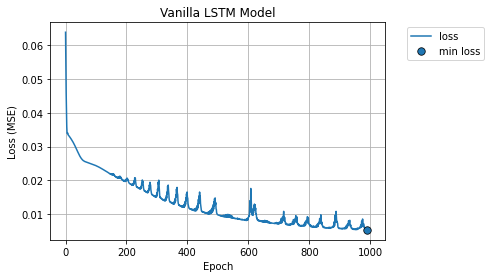

Minimum loss : 991    0.005288
Name: loss, dtype: float64




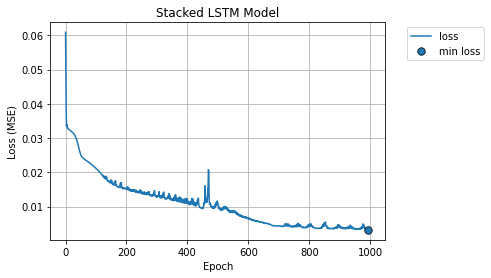

Minimum loss : 993    0.003186
Name: loss, dtype: float64




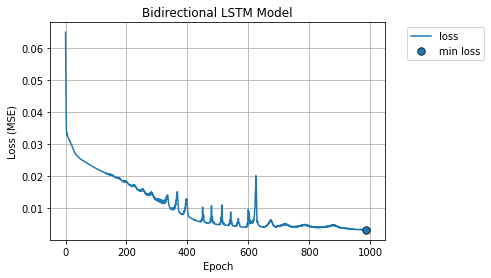

Minimum loss : 986    0.003261
Name: loss, dtype: float64




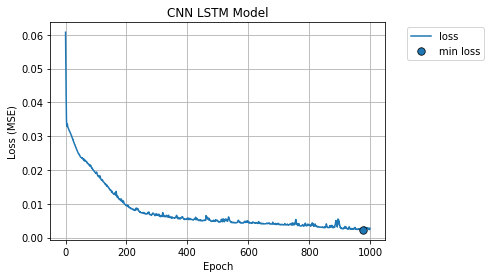

Minimum loss : 976    0.002263
Name: loss, dtype: float64




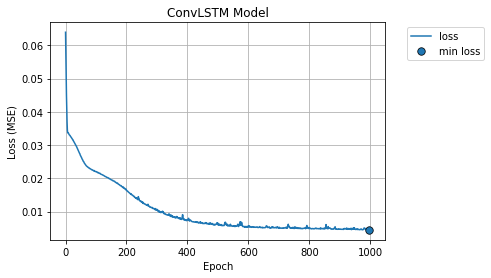

Minimum loss : 997    0.004477
Name: loss, dtype: float64




In [ ]:
# Evaluate models history loss

for history_df in histories_df:
  plt.title(history_df['name'])
  evaluate_history_loss(history_df['history'])
  print('\n')

### Cosine similarity

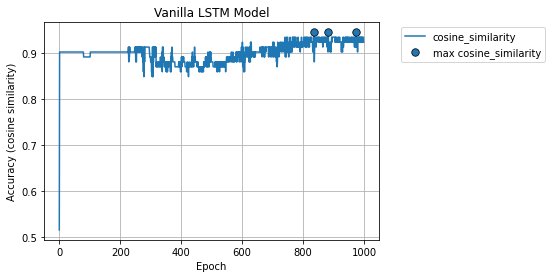

Maximum cosine similarity : 836    0.946236
883    0.946236
973    0.946236
Name: cosine_similarity, dtype: float64




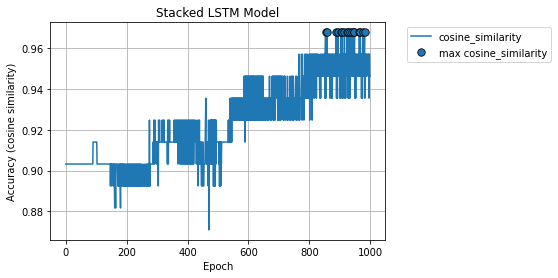

Maximum cosine similarity : 853    0.967742
858    0.967742
888    0.967742
893    0.967742
904    0.967742
907    0.967742
915    0.967742
923    0.967742
926    0.967742
934    0.967742
940    0.967742
945    0.967742
948    0.967742
964    0.967742
967    0.967742
975    0.967742
981    0.967742
Name: cosine_similarity, dtype: float64




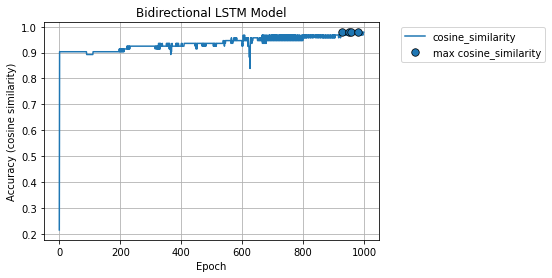

Maximum cosine similarity : 927    0.978495
950    0.978495
957    0.978495
979    0.978495
Name: cosine_similarity, dtype: float64




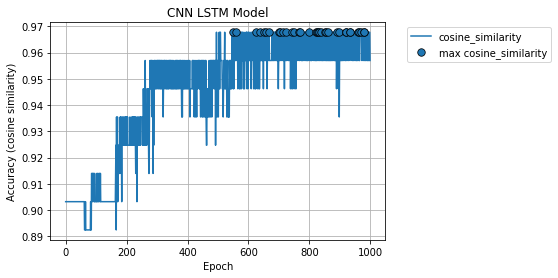

Maximum cosine similarity : 549    0.967742
560    0.967742
625    0.967742
638    0.967742
652    0.967742
656    0.967742
666    0.967742
700    0.967742
704    0.967742
714    0.967742
723    0.967742
743    0.967742
751    0.967742
767    0.967742
770    0.967742
798    0.967742
821    0.967742
824    0.967742
829    0.967742
832    0.967742
838    0.967742
851    0.967742
855    0.967742
860    0.967742
892    0.967742
897    0.967742
920    0.967742
921    0.967742
932    0.967742
934    0.967742
959    0.967742
963    0.967742
970    0.967742
978    0.967742
980    0.967742
Name: cosine_similarity, dtype: float64




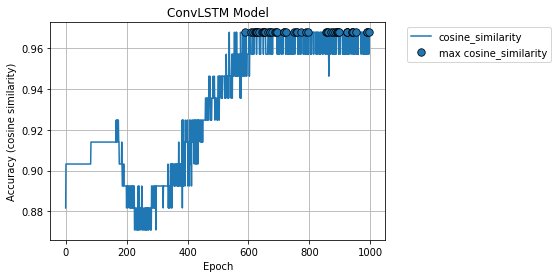

Maximum cosine similarity : 587    0.967742
607    0.967742
616    0.967742
622    0.967742
624    0.967742
625    0.967742
628    0.967742
629    0.967742
633    0.967742
644    0.967742
647    0.967742
650    0.967742
652    0.967742
654    0.967742
665    0.967742
671    0.967742
672    0.967742
676    0.967742
688    0.967742
691    0.967742
693    0.967742
715    0.967742
718    0.967742
723    0.967742
749    0.967742
756    0.967742
760    0.967742
771    0.967742
790    0.967742
794    0.967742
853    0.967742
858    0.967742
860    0.967742
870    0.967742
879    0.967742
883    0.967742
890    0.967742
892    0.967742
893    0.967742
894    0.967742
897    0.967742
923    0.967742
924    0.967742
925    0.967742
939    0.967742
941    0.967742
942    0.967742
953    0.967742
988    0.967742
989    0.967742
996    0.967742
Name: cosine_similarity, dtype: float64




In [ ]:
# Evaluate models history cosine_similarity

for history_df in histories_df:
  plt.title(history_df['name'])
  evaluate_history_cosine_similarity(history_df['history'])
  print('\n')

## **Predictions plot**

### Uninverted

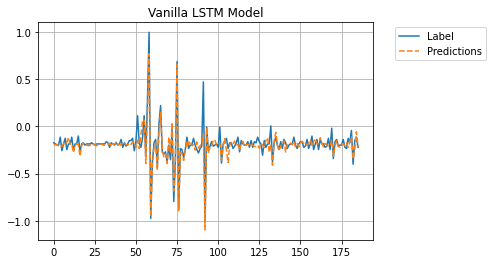

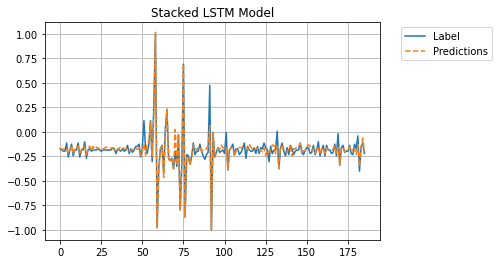

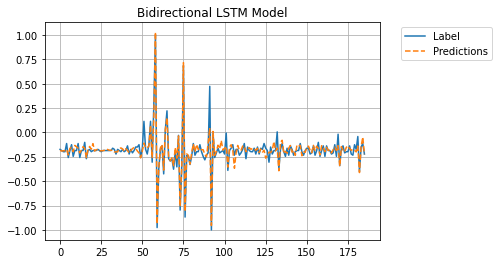

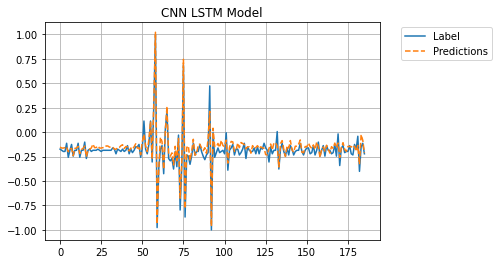

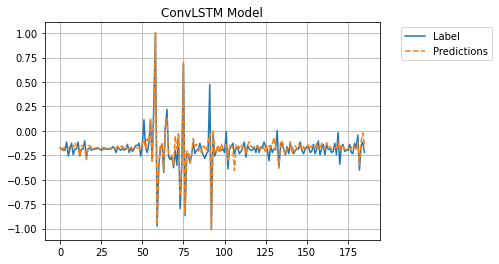

In [ ]:
# Show predictions plot

import warnings
warnings.filterwarnings("ignore")

for model in models:
  predictions = model['model'].predict(model['feature train'], verbose=0)
  predictions = predictions.reshape(len(predictions))
  plt.plot(range(0,len(predictions)), label_train, label='Label')
  plt.plot(range(0,len(predictions)), predictions, label='Predictions', ls='--')
  plt.title(model['name'])
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.grid(True)
  plt.show()
  print('\n')

### Inverted

In [ ]:
# Inverse scaling function

def inverse_scaling(series, scaler, test_scaled):
  temp = np.zeros((len(test_scaled), len(test_scaled[0])))
  temp[:, -1] = series.reshape(len(predictions))
  temp = scaler.inverse_transform(temp)
  inverted = temp[:, -1]
  return inverted

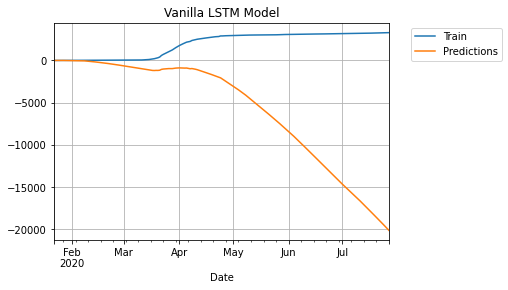

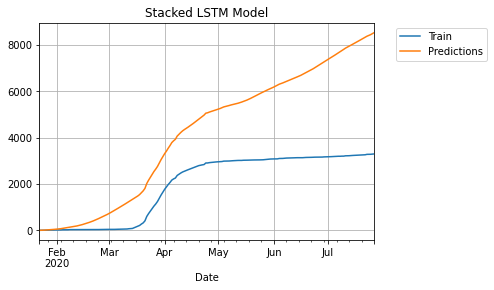

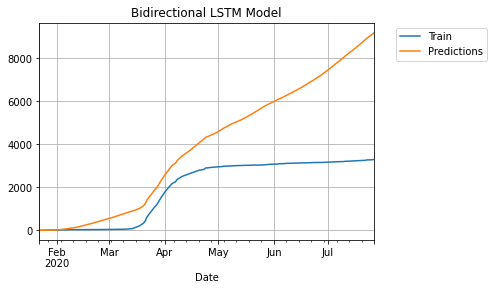

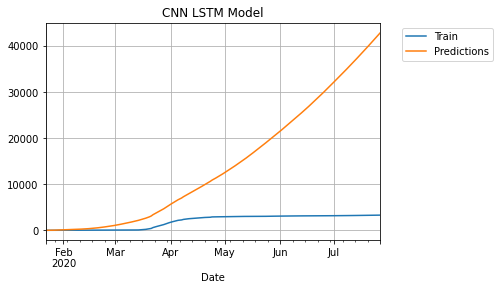

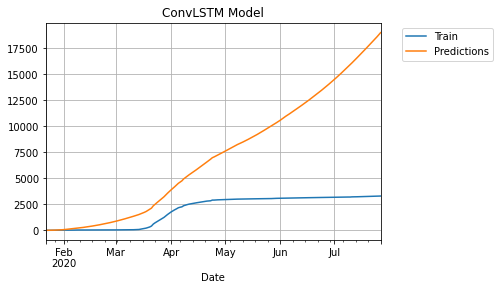

In [ ]:
# Show predictions plot

train_series = ts_df

for model in models:
  # Inverse scaling
  predictions = model['model'].predict(model['feature train'], verbose=0)
  predictions = inverse_scaling(predictions, scaler, train_scaled)
  # Inverse difference
  predictions = inverse_difference(train_series, predictions, times_diff)
  # Index = datetime
  predictions.index = train_series.index
  # Plot
  train_series.plot(label='Train')
  predictions.plot(label='Predictions')
  plt.title(model['name'])
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.grid(True)
  plt.show()
  print('\n')

## **Numerical metrics**

In [ ]:
test_series = ts_df

for model in models:
  # Inverse scaling
  predictions = model['model'].predict(model['feature train'], verbose=0)
  predictions = inverse_scaling(predictions, scaler, train_scaled)
  # Inverse difference
  predictions = inverse_difference(test_series, predictions, times_diff)
  # Index = datetime
  predictions.index = test_series.index
  # Evaluate metrics
  print("> ", model['name'])
  print("------------------------------------------")
  evaluate_metrics(test_series, predictions)
  print('\n')

>  Vanilla LSTM Model
------------------------------------------
R^2 score : -56.91606
MAE (Mean Absolute Error) : 7611.49365
MSE (Mean Squared Error) : 111024744.61366
RMSE (Root Mean Squared Error) : 10536.82801


>  Stacked LSTM Model
------------------------------------------
R^2 score : -2.80378
MAE (Mean Absolute Error) : 2228.25322
MSE (Mean Squared Error) : 7291832.14031
RMSE (Root Mean Squared Error) : 2700.33926


>  Bidirectional LSTM Model
------------------------------------------
R^2 score : -2.61319
MAE (Mean Absolute Error) : 1997.27945
MSE (Mean Squared Error) : 6926463.44060
RMSE (Root Mean Squared Error) : 2631.81752


>  CNN LSTM Model
------------------------------------------
R^2 score : -154.16018
MAE (Mean Absolute Error) : 12347.76408
MSE (Mean Squared Error) : 297441172.21462
RMSE (Root Mean Squared Error) : 17246.48289


>  ConvLSTM Model
------------------------------------------
R^2 score : -24.12637
MAE (Mean Absolute Error) : 5210.23724
MSE (Mean Squared 